# Credit Card Customer Segmentation

We’ve a dataset containing information about the company’s clients and we will segment them into different groups in order to apply different business strategies for each type of customer.

The company expects to receive a group for each client and also an explanation of the characteristics of each group and what are the main points that make them different.

We will use the K-means algorithm to segment the data.

In order to use the algorithm properly and achieve all the goals that the company has set for us, we'll go through the following steps:

Analyze the dataset;
Prepare the data for modeling;
Find an appropriate number of clusters;
Segment the data;
Interpret and explain the results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

np.random.seed(42)

sns.set_style('whitegrid')

### Exploratory Data Analysis

In [2]:
df=pd.read_csv('datasets\customer_segmentation.csv')
df.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [3]:
df.shape

(10127, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

There are 10127 rows and 14 columns in the dataset including a unique identifier for each client, which is not going to be needed for the segmentation.

Of the 13 columns left, there are 8 columns containing integers, 2 containing floats, and 3 columns containing strings, which means we have 3 categorical columns to deal with.

Also, there are no missing values.

In [5]:
categorical_cols=['gender', 'education_level', 'marital_status']

for col in categorical_cols:
    print(col)
    print(df[col].value_counts(), end='\n\n')

gender
gender
F    5358
M    4769
Name: count, dtype: int64

education_level
education_level
Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: count, dtype: int64

marital_status
marital_status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: count, dtype: int64



As we're working with unsupervised machine learning, there isn't a target variable on which we can measure the impacts of the other variables.

But we can see the correlation between the numeric variables and their distributions.

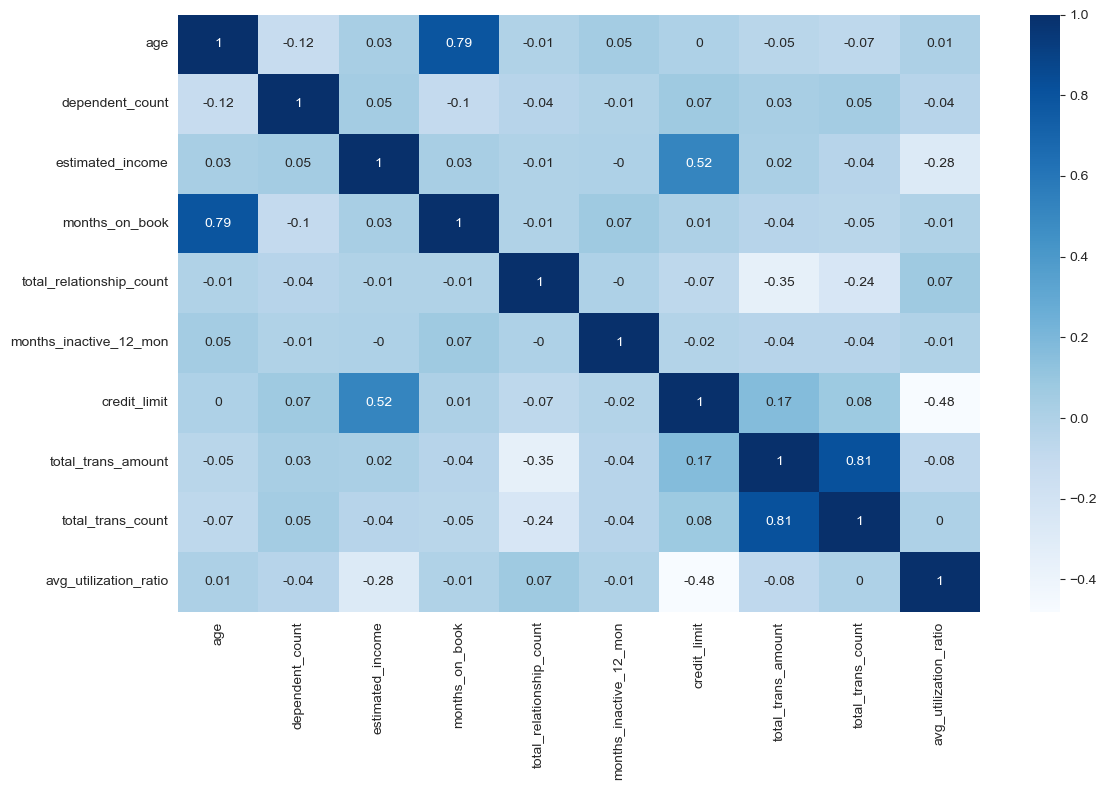

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(round(df.select_dtypes(exclude='object').drop('customer_id', axis=1).corr(), 2), cmap='Blues', annot=True, ax=ax)

plt.tight_layout()
plt.show()

Most of the variables present weak correlations between each other, but there are some we can highlight:

- Age is strongly correlated with how long the person has been a customer (months_on_book);
- Credit limit is positively correlated with the estimated income and negatively correlated with the average utilization ratio;
- The total number of transactions (total_trans_count) is strongly correlated with the total amount transitioned (total_trans_amount).

C:\Users\Ibrahim\AppData\Local\Temp\ipykernel_14988\579634717.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.drop('customer_id', axis=1).hist(ax=ax)


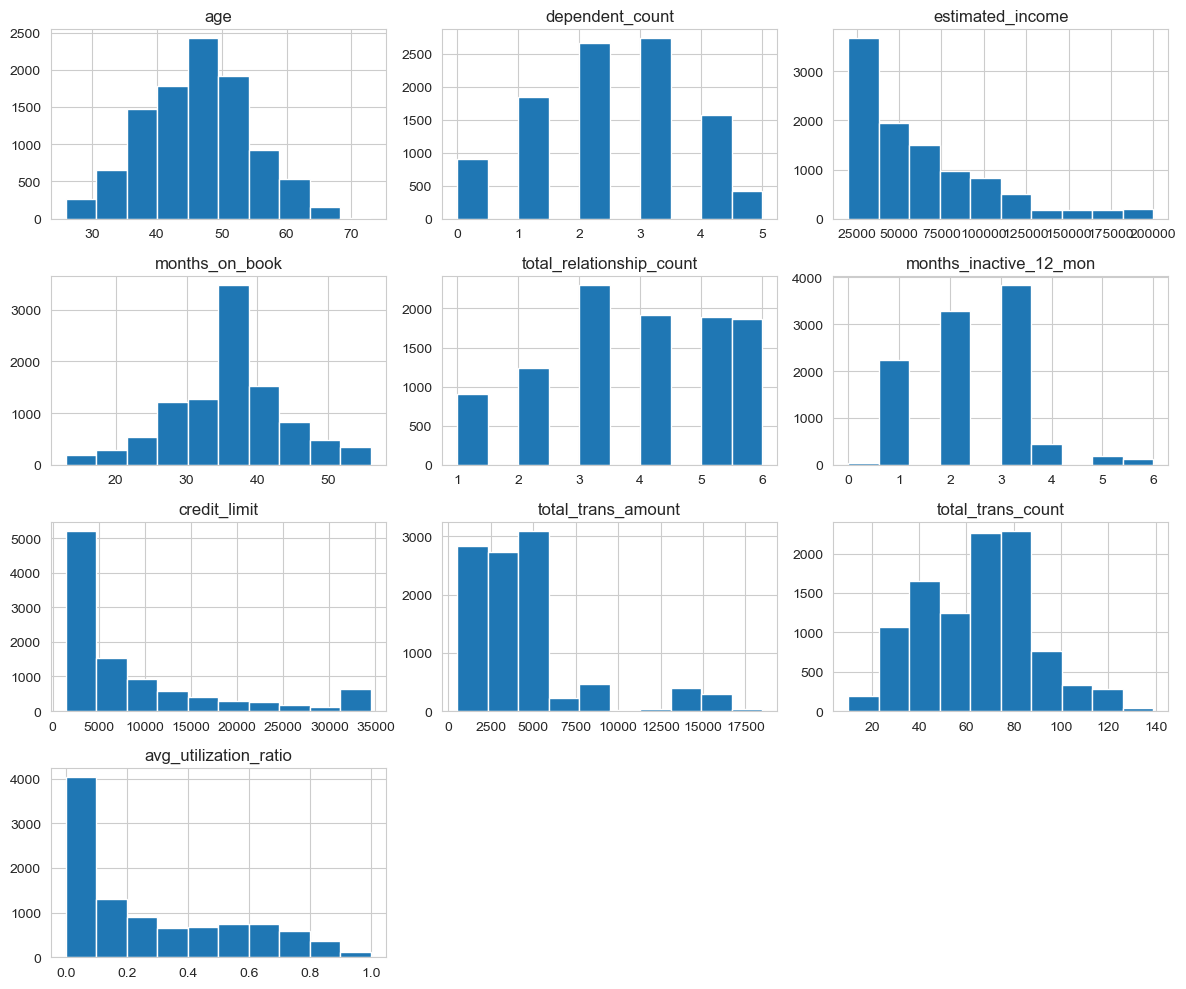

In [7]:
fig, ax = plt.subplots(figsize=(12, 10))

#Removing the customer's id before plotting the distributions
df.drop('customer_id', axis=1).hist(ax=ax)

plt.tight_layout()
plt.show()

Regarding distributions, we have a couple of them closer to a normal distribution, but most of them are skewed.

### Feature Engineering

We're now dealing with the 3 categorical variables.

The gender column is the easiest one. We'll use a lambda function to replace the values with ones and zeros.

We'll also be able to transform the education_level column to numeric. We'll use the replace() method to perform this task. This method will assign a value to each level of education:

- Uneducated - 0
- High School - 1
- College - 2
- Graduate - 3
- Post-Graduate - 4
- Doctorate - 5

Unfortunately, we can't do the same for this marital_status column as there is no level of magnitude between "Single", "Married" or "Divorced", for example. We can't say that any of them is higher or better than the others. Therefore, we'll use one-hot-encoding to create dummy variables from this column and then drop the original variable.

In [8]:
df_modif=df.copy()
education_map={'Uneducated' : 0, 'High School' : 1, 'College' : 2,'Graduate' : 3, 'Post-Graduate' : 4,'Doctorate' : 5}
df_modif['gender']=df_modif['gender'].map({'M':1,'F':0})
df_modif['education_level']=df_modif['education_level'].map(education_map)

In [9]:
df_modif.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,1,3,1,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,0,5,3,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,1,3,3,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,0,4,1,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,1,3,0,Married,65000,21,5,1,4716.0,816,28,0.000


In [10]:
dummies=pd.get_dummies(df_modif['marital_status']).astype(int)
df_modif=pd.concat([df_modif,dummies], axis=1)
df_modif.drop(['marital_status','Unknown'], axis=1, inplace=True)
df_modif.head()

,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,Divorced,Married,Single
0,768805383,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,0,1,0
1,818770008,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,0,1
2,713982108,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,0,1,0
3,769911858,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,0,0,0
4,709106358,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,0,1,0


### Scaling the Data

In [11]:
df_modif=df_modif.drop('customer_id', axis=1)

In [12]:
scaler=StandardScaler()
scaler.fit(df_modif)
data_scaled=scaler.transform(df_modif)
print(data_scaled[:5])

[[-0.16540558  1.05995565  0.50336813 -0.75221102  0.1758098   0.38462088
   0.76394261 -1.32713603  0.4466219  -0.95970657 -0.97389518 -0.77588223
  -0.2824051   1.07733799 -0.79850685]
 [ 0.33357038 -0.9434357   2.04319867  0.66278684 -0.96716585  1.01071482
   1.40730617 -1.32713603 -0.04136665 -0.91643261 -1.35734038 -0.61627565
  -0.2824051  -0.92821381  1.2523374 ]
 [ 0.58305837  1.05995565  0.50336813  0.66278684  0.78539682  0.00896451
   0.12057905 -1.32713603 -0.5736978  -0.74098169 -1.91120566 -0.99715499
  -0.2824051   1.07733799 -0.79850685]
 [-0.78912553 -0.9434357   1.2732834  -0.75221102 -0.63697289 -0.24147306
  -0.52278451  1.64147829 -0.58525108 -0.95175829 -1.91120566  1.75968594
  -0.2824051  -0.92821381 -0.79850685]
 [-0.78912553  1.05995565  0.50336813 -1.45970995  0.07421197 -1.86931731
   0.76394261 -1.32713603 -0.43087725 -1.05626345 -1.57036549 -0.99715499
  -0.2824051   1.07733799 -0.79850685]]


### Choosing K

In [13]:
df_scaled=pd.DataFrame(data_scaled)

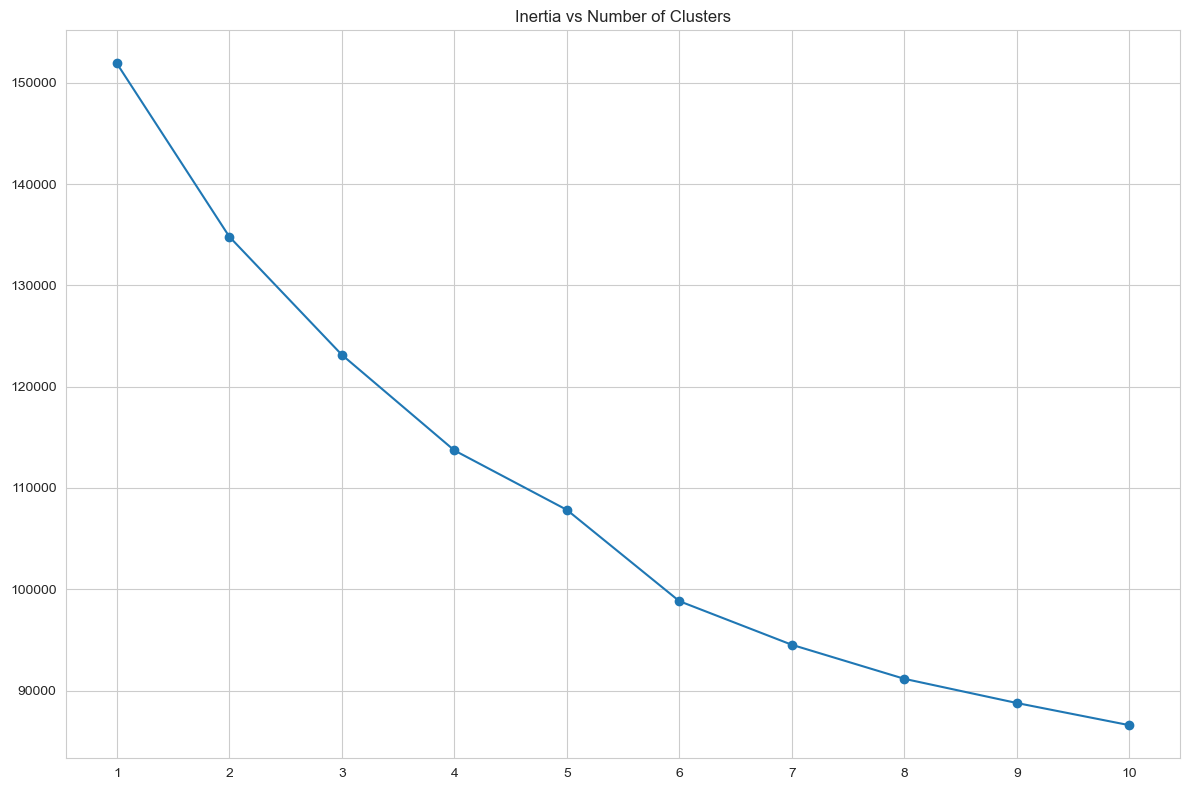

In [14]:
inertias=[]

for k in range(1,11):
    model=KMeans(n_clusters=k)
    model.fit_predict(df_scaled)
    inertias.append(model.inertia_)

plt.figure(figsize=(12,8))
plt.plot(range(1,11), inertias, marker='o')
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.title('Inertia vs Number of Clusters')

plt.tight_layout()
plt.show()

It looks like the rate of decreasing of the inertia slows down between 5 and 7 clusters. We'll use 6 clusters to move on.

In [15]:
model=KMeans(n_clusters=6)
clusters= model.fit_predict(df_scaled)
print(clusters)

[3 4 3 ... 2 4 2]


### Analyzing Results

In [16]:
df['CLUSTER']=clusters+1
df['CLUSTER'].value_counts()

CLUSTER
5    2608
3    2597
4    1809
1    1445
6     934
2     734
Name: count, dtype: int64

We can see that cluster 5 is the largest while cluster 2 is the smallest.

Considering the numeric variable only, we'll check on the average value of each variable per cluster. We just need to group the data and plot a bar chart for each column.

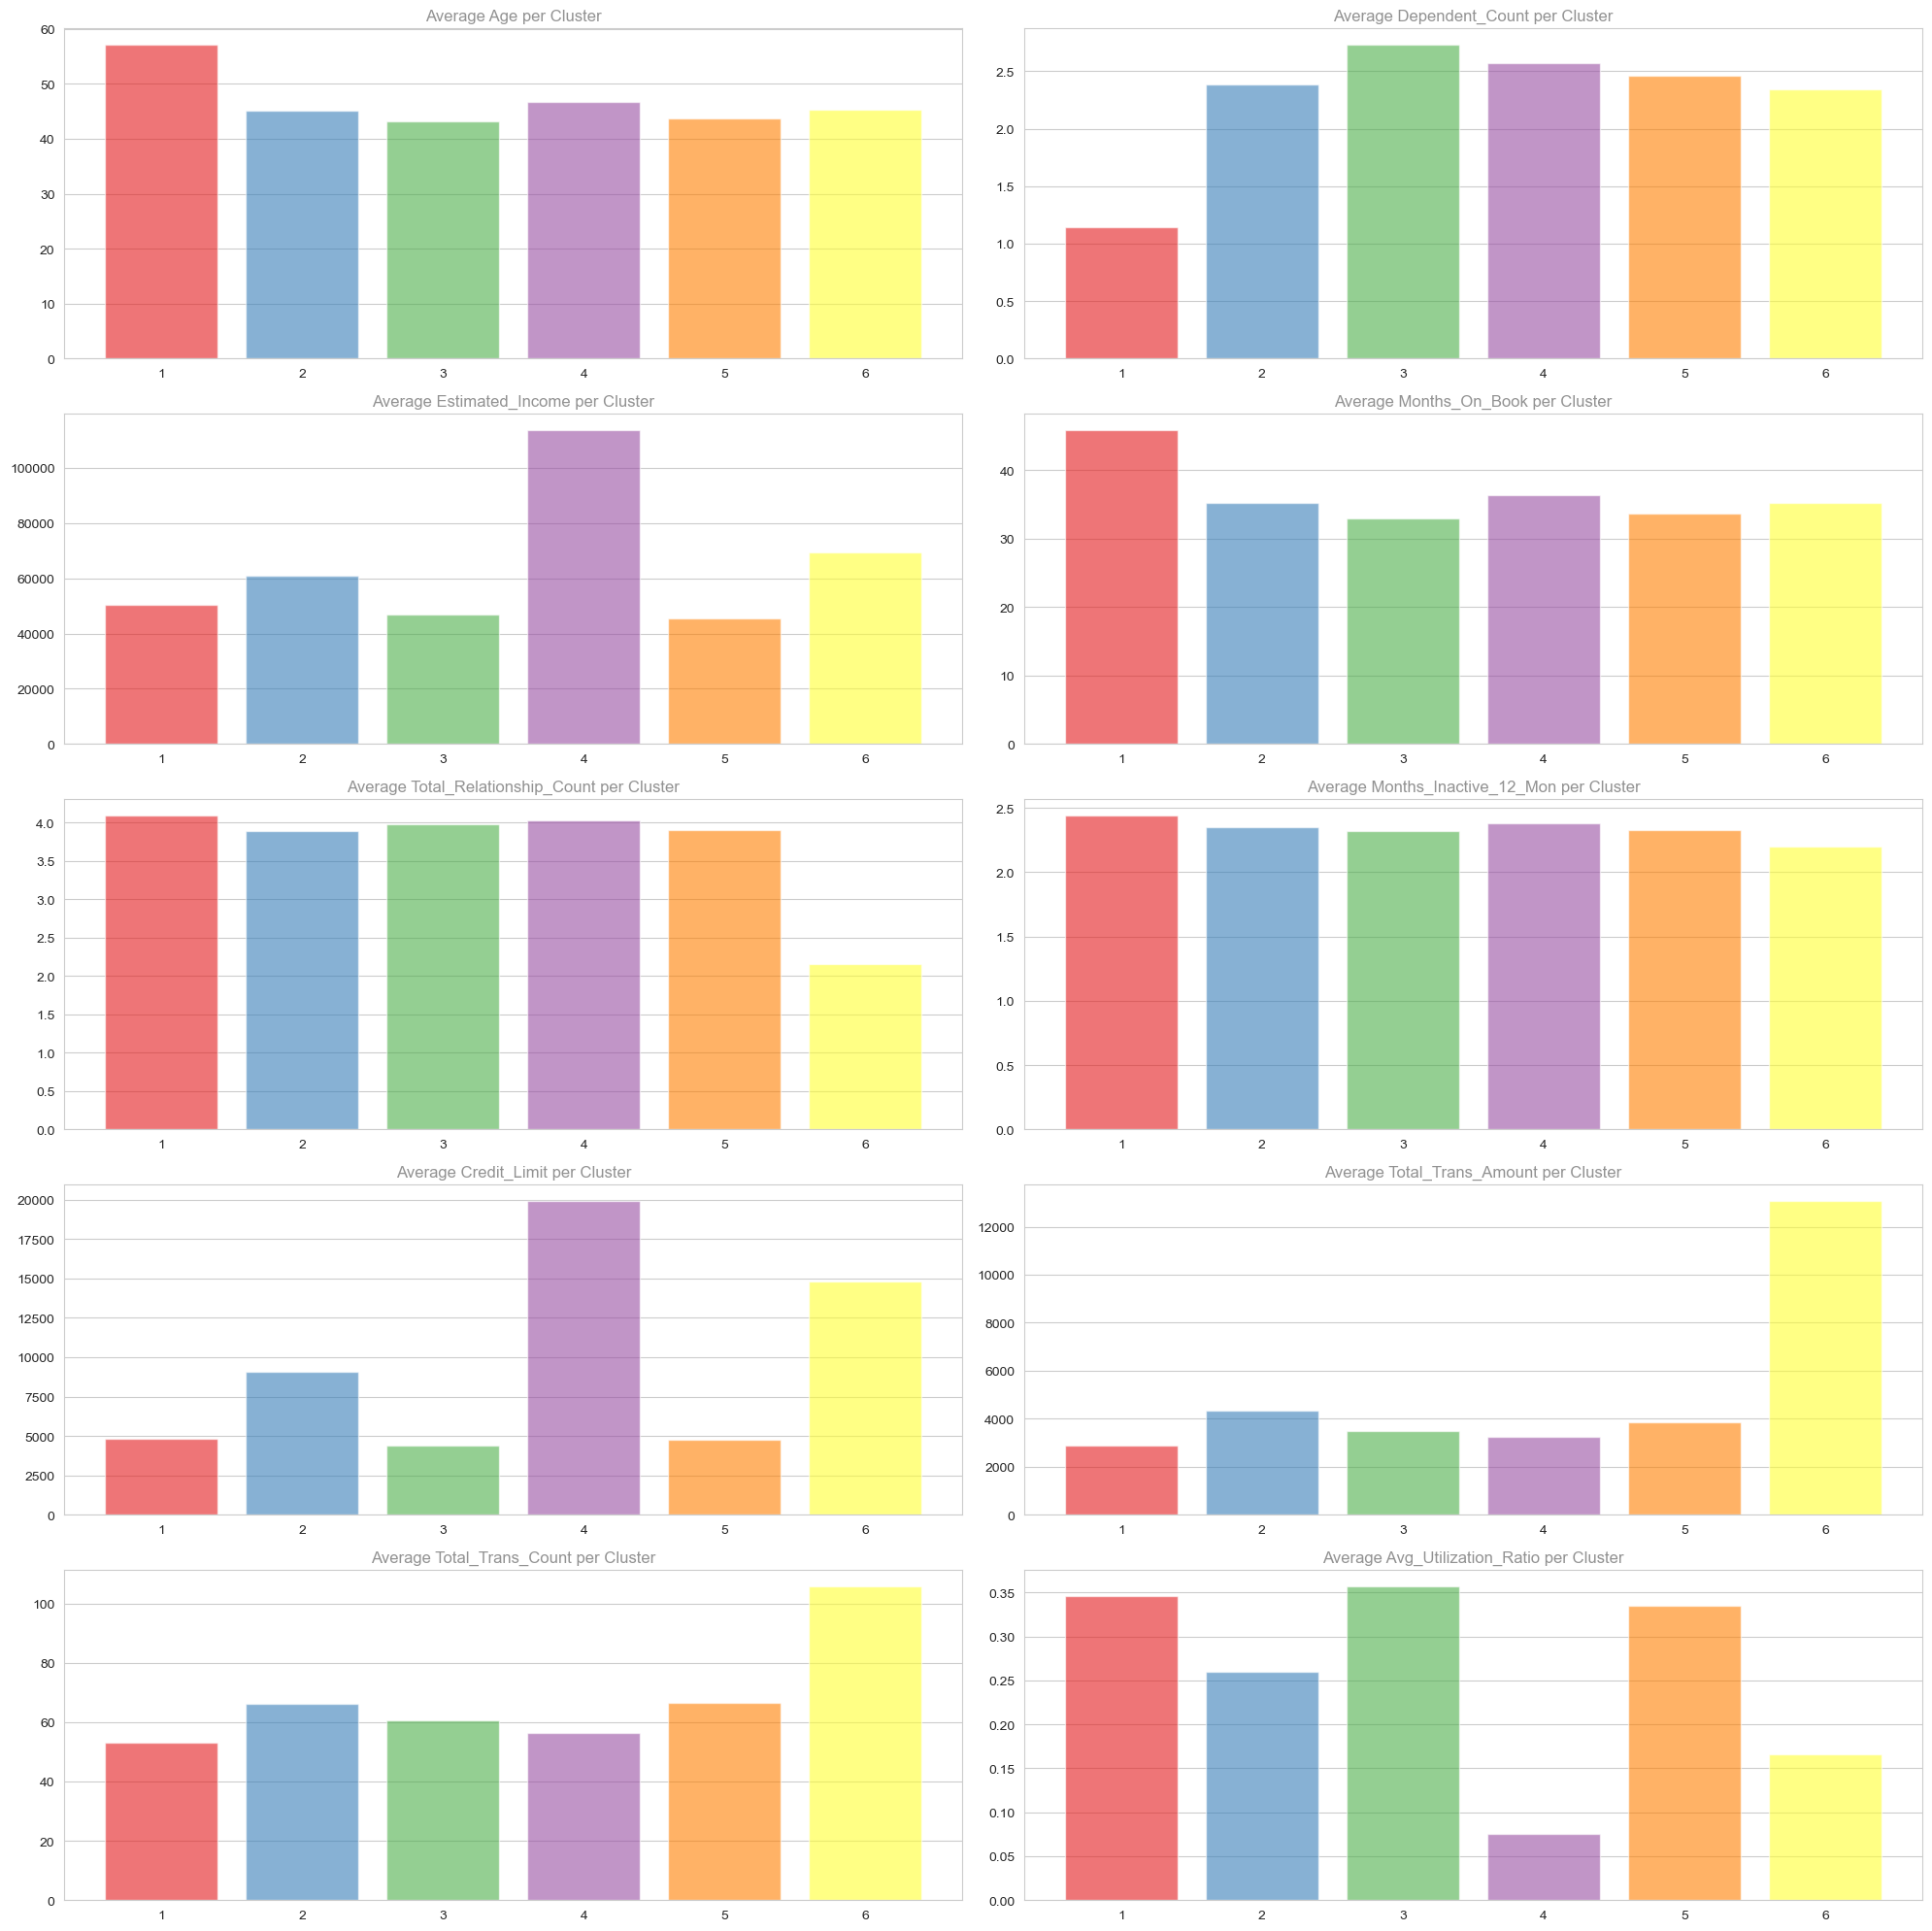

In [17]:
df['CLUSTER']=clusters+1

numeric_columns=df.select_dtypes(exclude='object').drop(['customer_id', 'CLUSTER'], axis=1).columns

fig = plt.figure(figsize=(20, 20))
for i, column in enumerate(numeric_columns):
    df_plot = df.groupby('CLUSTER')[column].mean()
    ax = fig.add_subplot(5, 2, i+1)
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.set_title(f'Average {column.title()} per Cluster', alpha=0.5)
    ax.xaxis.grid(False)
    
plt.tight_layout()
plt.show()

For those numerical variables with higher correlations we saw earlier, we can also use a scatter plot to visualize this correlation grouped by clusters and analyze how the clusters change between each area of the chart.

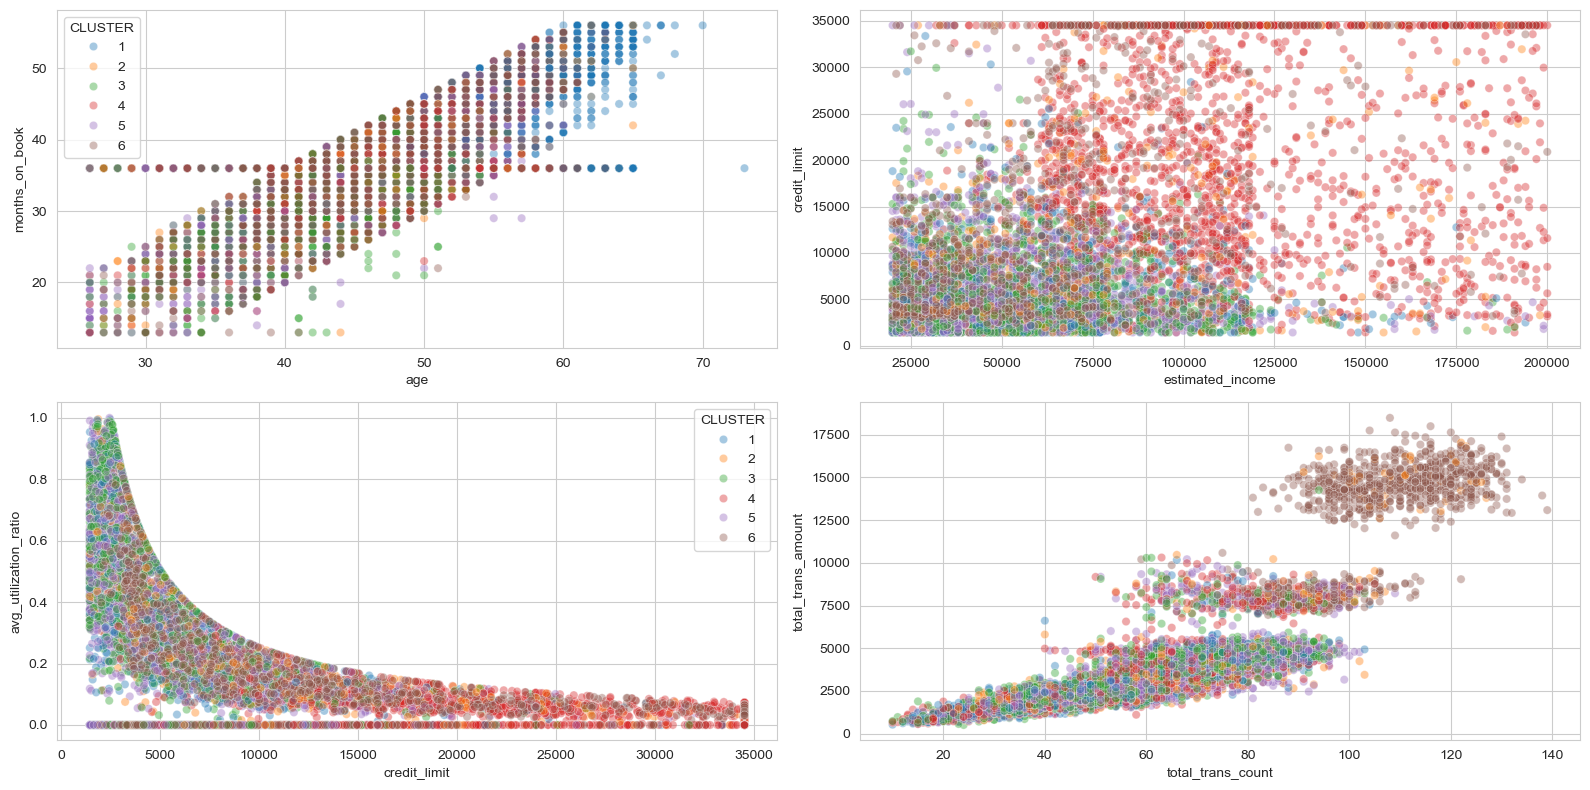

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
sns.scatterplot(x='age', y='months_on_book', hue='CLUSTER', data=df, palette='tab10', alpha=0.4, ax=ax1)
sns.scatterplot(x='estimated_income', y='credit_limit', hue='CLUSTER', data=df, palette='tab10', alpha=0.4, ax=ax2, legend=False)
sns.scatterplot(x='credit_limit', y='avg_utilization_ratio', hue='CLUSTER', data=df, palette='tab10', alpha=0.4, ax=ax3)
sns.scatterplot(x='total_trans_count', y='total_trans_amount', hue='CLUSTER', data=df, palette='tab10', alpha=0.4, ax=ax4, legend=False)

plt.tight_layout()
plt.show()

We can draw some early conclusions considering only the numeric variables.

For instance, Cluster 6 has the highest amount of money transitioned, while Cluster 5 has the lowest credit limit and estimated income and the highest utilization rate. Cluster 4 has the highest credit limit. Older clients are grouped in Cluster 1.

For the categorical columns, we'll plot the percentual distribution of each variable in each cluster. This will allow us to verify if a particular cluster is mostly composed of men, or of married people only, for example.

C:\Users\Ibrahim\AppData\Local\Temp\ipykernel_14988\4107536158.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)
C:\Users\Ibrahim\AppData\Local\Temp\ipykernel_14988\4107536158.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)
C:\Users\Ibrahim\AppData\Local\Temp\ipykernel_14988\4107536158.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


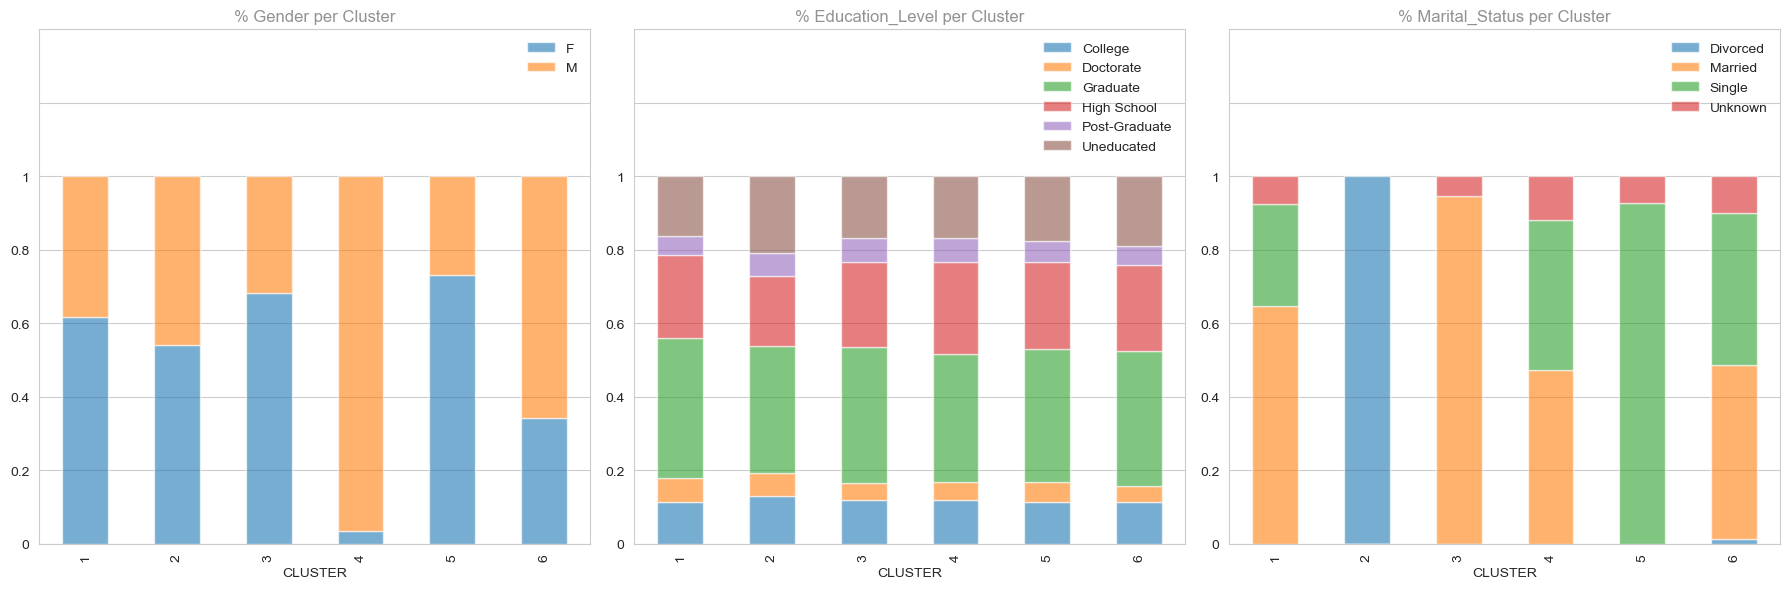

In [19]:
cat_columns = df.select_dtypes(include=['object'])

fig = plt.figure(figsize=(18, 6))
for i, col in enumerate(cat_columns):
    plot_df = pd.crosstab(index=df['CLUSTER'], columns=df[col], values=df[col], aggfunc='size', normalize='index')
    ax = fig.add_subplot(1, 3, i+1)
    plot_df.plot.bar(stacked=True, ax=ax, alpha=0.6)
    ax.set_title(f'% {col.title()} per Cluster', alpha=0.5)

    ax.set_ylim(0, 1.4)
    ax.legend(frameon=False)
    ax.xaxis.grid(False)
    
    labels = [0, 0.2, 0.4, 0.6, 0.8, 1]
    ax.set_yticklabels(labels)

plt.tight_layout()
plt.show()

Considering the categorical variables, we notice that the education level is well divided between clusters.

In other highlights, Cluster 5 is composed almost entirely of married people, while everybody in Cluster 2 is divorced. Cluster 4 is almost completely male and Cluster 5 is composed almost entirely of single people.